In [136]:
import pandas as pd
import numpy as np

In [137]:
df = pd.read_csv("csv/FinalizedSubjects.csv")
df.shape

(43043, 23)

In [138]:
df.head()

,Subject,Pside_AnkleAngles,Pside_KneeAngles,Pside_HipAngles,Pside_PelvisAngles,Pside_GASnorm,Pside_RFnorm,Pside_VLnorm,Pside_BFnorm,Pside_STnorm,...,Nside_KneeAngles,Nside_HipAngles,Nside_PelvisAngles,Nside_GASnorm,Nside_RFnorm,Nside_VLnorm,Nside_BFnorm,Nside_STnorm,Nside_TAnorm,Nside_ERSnorm
0,Sub01,12.785372,14.768345,8.673370,4.616966,0.454807,0.301307,0.311426,0.315061,0.420217,...,-0.698328,2.736246,6.190703,0.208961,0.337156,0.271426,0.265745,0.223880,0.145799,0.216146
1,Sub01,12.753109,31.944736,28.798993,5.098909,0.246841,0.497978,0.449163,0.177307,0.159350,...,12.582941,5.574530,-4.143467,0.509914,0.379921,0.228640,0.215840,0.221332,0.263735,0.454640
2,Sub01,12.751324,31.943535,28.882702,5.119237,0.246212,0.497692,0.448465,0.179978,0.158217,...,12.531719,5.562897,-4.168033,0.516586,0.377485,0.230339,0.214898,0.221352,0.255613,0.457775
3,Sub01,12.749987,31.943076,28.965911,5.139552,0.243798,0.495053,0.445028,0.183024,0.156763,...,12.481332,5.551675,-4.192448,0.521968,0.373820,0.231353,0.216444,0.218676,0.248617,0.460112
4,Sub01,12.749111,31.943274,29.048613,5.159854,0.240705,0.491110,0.439072,0.185615,0.154699,...,12.431806,5.540889,-4.216712,0.527712,0.371193,0.231678,0.219827,0.213311,0.244245,0.461692


In [ ]:
# Mapping of subject IDs to their corresponding Tinetti POMA scores
TINETTI_POMA_MAPPING = {
    'Sub01': 23, 'Sub02': 27, 'Sub03': 14, 'Sub04': 21, 'Sub05': 15,
    'Sub06': 26, 'Sub07': 21, 'Sub08': 21, 'Sub09': 19, 'Sub10': 18,
    'Sub11': 12, 'Sub12': 26, 'Sub13': 11, 'Sub14': 20, 'Sub15': 17,
    'Sub16': 28, 'Sub17': 13, 'Sub18': 19, 'Sub19': 16, 'Sub20': 21,
    'Sub21': 24, 'Sub22': 15, 'Sub23': 21, 'Sub24': 17, 'Sub25': 7,
    'Sub26': 18, 'Sub27': 20, 'Sub28': 14, 'Sub29': 23, 'Sub30': 12,
    'Sub31': 10, 'Sub32': 21, 'Sub33': 8,  'Sub34': 13, 'Sub35': 23,
    'Sub36': 8,  'Sub37': 13, 'Sub38': 27, 'Sub39': 28, 'Sub40': 28,
    'Sub41': 6,  'Sub42': 15, 'Sub43': 22, 'Sub44': 28, 'Sub45': 21,
    'Sub46': 12, 'Sub47': 20, 'Sub48': 24, 'Sub49': 25, 'Sub50': 26
}


In [140]:
EPOCH = 40

In [ ]:
# Extract Pside and Nside feature columns
pside_cols = [col for col in df.columns if col.startswith("Pside")]
nside_cols = [col for col in df.columns if col.startswith("Nside")]
feature_cols = pside_cols + nside_cols  # total feature count should be 22

# Get subject identifiers and dataset dimensions
subjects = df["Subject"].unique()
n_subjects = len(subjects)
n_samples = 1001
n_features = len(feature_cols)

# Allocate arrays for data and labels
data = np.zeros((n_subjects, n_samples, n_features))
labels = np.zeros((n_subjects, 1))

# Fill data and labels per subject
for i, subject in enumerate(subjects):
    subject_df = df[df["Subject"] == subject][feature_cols]

    if subject_df.shape[0] < n_samples:
        raise ValueError(f"{subject} has only {subject_df.shape[0]} samples (needs 1001)")

    subject_data = subject_df[:n_samples].to_numpy()

    # Replace NaN values with 0 if present
    if np.isnan(subject_data).any():
        print(f"⚠️ NaNs found in {subject}, filling with 0.")
        subject_data = np.nan_to_num(subject_data)

    data[i] = subject_data
    labels[i] = TINETTI_POMA_MAPPING[subject]

# Save processed data and labels to .npz file
np.savez("data.npz", data=data, labels=labels)

# Display confirmation and dataset info
print("Saved to data.npz")
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
print("Any NaNs in data?", np.isnan(data).any())
print("Any NaNs in labels?", np.isnan(labels).any())


Saved to data.npz
Data shape: (43, 1001, 22)
Labels shape: (43, 1)
Any NaNs in data? False
Any NaNs in labels? False


In [ ]:
def get_fall_risk(poma: float) -> str: 
    # Determine fall risk category based on POMA score
    if poma <= 18:
        return "High fall risk"
    elif 18 < poma < 24:
        return "Moderate fall risk"
    elif 24 <= poma <= 28:
        return "Low fall risk"
    else:
        return "Out of range"


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load saved dataset
npz = np.load("data.npz")
data = npz["data"]     # shape: (subjects, 1001, features)
labels = npz["labels"]

n_subjects, n_samples, n_features = data.shape

# Reshape data for scaling (combine all subjects and samples into one 2D array)
data_reshaped = data.reshape(-1, n_features)

# Apply standard scaling across features
scaler = StandardScaler()
data_reshaped = scaler.fit_transform(data_reshaped)

# Reshape scaled data back to original 3D format
data_scaled = data_reshaped.reshape(n_subjects, n_samples, n_features)

# Save scaled dataset
np.savez("data_scaled.npz", data=data_scaled, labels=labels)


In [ ]:
def get_subject_index_by_id(id_: str) -> int:
    # Return the index position of a subject given its ID
    subjects = df["Subject"].unique()
    if id_ not in subjects:
        raise ValueError(f"Subject ID {id_} not found.")
    return list(subjects).index(id_)


Training [No Windowing]...
[NoWin] Epoch 10/30 - Loss: 13.2135
[NoWin] Epoch 20/30 - Loss: 6.4293
[NoWin] Epoch 30/30 - Loss: 4.5140
Saved NoWin model to saved_models/NoWin_model.pth

Training [With Windowing]...
[Win] Epoch 10/30 - Loss: 3.4796
[Win] Epoch 20/30 - Loss: 0.5086
[Win] Epoch 30/30 - Loss: 0.4858
Saved Win model to saved_models/Win_model.pth

=== Results Comparison ===
No Windowing (Window-level):
  MSE: 49.8281, RMSE: 7.0589, MAE: 4.4436, R²: -0.4063
With Windowing (Subject-level aggregation):
  MSE: 3.0091, RMSE: 1.7347, MAE: 1.1766, R²: 0.9288


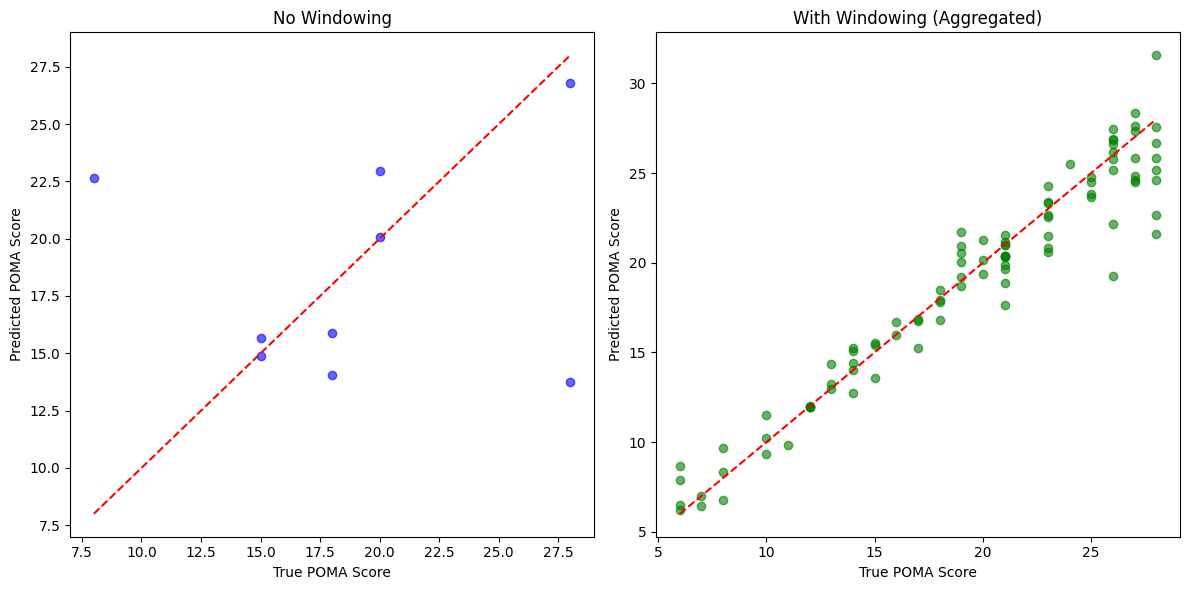

In [ ]:
"""
POMA Score Prediction using CNNs on EMG + Kinematic Data
=========================================================
This script trains convolutional neural networks (CNNs) to predict the Tinetti POMA 
score (a clinical fall-risk indicator) from multi-channel EMG/feature sequences.

Two training approaches are compared:
1. **No Windowing:** One sequence per subject (e.g., 1001 time samples).
2. **With Windowing:** Overlapping fixed-length segments per subject (e.g., 400-sample windows).

The model learns to map multivariate time-series signals to a scalar POMA score.
Performance is evaluated at both window-level and subject-level granularity.
"""

# ==============================
# Imports
# ==============================
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from collections import defaultdict
import os

# ==============================
# Parameters
# ==============================
WINDOW_SIZE = 400      # Sliding window length (number of time samples)
STRIDE = 60            # Step size for windowing (controls overlap)
EPOCHS = 30            # Training epochs per model
BATCH_SIZE = 16        # Batch size for DataLoader
LR = 0.001             # Learning rate for Adam optimizer
SAVE_DIR = "saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# ==============================
# Load Preprocessed Data
# ==============================
npz = np.load("data_scaled.npz")
data = npz["data"]     # shape: (subjects, time, features)
labels = npz["labels"] # shape: (subjects, 1)

# ==============================
# Utility Functions
# ==============================

def create_windows(data, labels, window_size, stride):
    """
    Slice each subject's time-series into overlapping windows.

    Args:
        data (np.ndarray): Shape (subjects, time, features)
        labels (np.ndarray): Corresponding POMA labels per subject
        window_size (int): Number of samples per window
        stride (int): Step size between window starts

    Returns:
        windows (np.ndarray): All windows stacked, shape (num_windows, window_size, features)
        window_labels (np.ndarray): Repeated subject labels per window
        subj_ids (np.ndarray): Subject index for each window (for aggregation)
    """
    windows, window_labels, subj_ids = [], [], []
    for subj_idx in range(data.shape[0]):
        subj_data = data[subj_idx]  # (time, features)
        subj_label = labels[subj_idx][0]

        # Create overlapping segments
        for start in range(0, subj_data.shape[0] - window_size + 1, stride):
            end = start + window_size
            windows.append(subj_data[start:end])
            window_labels.append(subj_label)
            subj_ids.append(subj_idx)

    return np.array(windows), np.array(window_labels), np.array(subj_ids)

# ==============================
# Dataset Class
# ==============================

class PomaDataset(Dataset):
    """Custom PyTorch dataset for (window, label) pairs."""
    def __init__(self, X, y, subj_ids=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
        self.subj_ids = subj_ids

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.subj_ids[idx]

# ==============================
# CNN Model Definition
# ==============================

class PomaCNN(nn.Module):
    """
    1D Convolutional Neural Network for regression on multichannel time-series.
    Architecture:
        Conv1d(22 -> 64) → ReLU → Conv1d(64 -> 128) → ReLU → AdaptiveAvgPool(32)
        → Flatten → FC(128*32 -> 64) → ReLU → FC(64 -> 1)
    """
    def __init__(self, in_channels=22):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.pool = nn.AdaptiveAvgPool1d(32)  # Reduces temporal dimension to 32
        self.fc1 = nn.Linear(128*32, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        """
        Forward pass of CNN.
        Input shape: (batch, channels, time)
        Output shape: (batch, 1)
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)   # Flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ==============================
# Training + Evaluation Function
# ==============================

def train_and_eval(X, y, subj_ids, epochs=EPOCHS, name=""):
    """
    Train and evaluate the CNN model for POMA regression.

    Args:
        X (np.ndarray): Input data, shape (samples, channels, time)
        y (np.ndarray): Continuous labels (POMA scores)
        subj_ids (np.ndarray): Subject identifiers for each sample
        epochs (int): Number of training epochs
        name (str): Model name (used for saving)

    Returns:
        dict: Window-level and subject-level performance metrics and predictions
    """
    # ----------------------------
    # Split into train and test sets
    # ----------------------------
    X_train, X_test, y_train, y_test, subj_train, subj_test = train_test_split(
        X, y, subj_ids, test_size=0.2, random_state=42
    )

    # Dataset + Dataloader
    train_ds = PomaDataset(X_train, y_train, subj_train)
    test_ds = PomaDataset(X_test, y_test, subj_test)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Model setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PomaCNN(in_channels=X.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()

    # ----------------------------
    # Training loop
    # ----------------------------
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for xb, yb, _ in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if (epoch+1) % 10 == 0:
            print(f"[{name}] Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")

    # Save trained model
    save_path = os.path.join(SAVE_DIR, f"{name}_model.pth")
    torch.save(model.state_dict(), save_path)
    print(f"✅ Saved {name} model to {save_path}")

    # ----------------------------
    # Evaluation
    # ----------------------------
    model.eval()
    preds, targets, subj_list = [], [], []
    with torch.no_grad():
        for xb, yb, subj in test_loader:
            xb = xb.to(device)
            out = model(xb)
            preds.extend(out.cpu().numpy().flatten())
            targets.extend(yb.cpu().numpy().flatten())
            subj_list.extend(subj)

    # Window-level metrics
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)
    mae = mean_absolute_error(targets, preds)
    results = {
        "window_preds": preds, "window_targets": targets, "window_subj": subj_list,
        "mse": mse, "rmse": np.sqrt(mse), "mae": mae, "r2": r2
    }

    # ----------------------------
    # Subject-level aggregation
    # ----------------------------
    subj_preds = defaultdict(list)
    subj_true = {}
    for p, t, s in zip(preds, targets, subj_list):
        subj_preds[s].append(p)
        subj_true[s] = t
    y_pred_subj = [np.mean(v) for v in subj_preds.values()]
    y_true_subj = [subj_true[s] for s in subj_preds.keys()]

    mse_s = mean_squared_error(y_true_subj, y_pred_subj)
    r2_s = r2_score(y_true_subj, y_pred_subj)
    mae_s = mean_absolute_error(y_true_subj, y_pred_subj)

    results.update({
        "subj_preds": y_pred_subj, "subj_targets": y_true_subj,
        "mse_s": mse_s, "rmse_s": np.sqrt(mse_s), "mae_s": mae_s, "r2_s": r2_s
    })

    return results

# ==============================
# Training: No Windowing
# ==============================
# Each subject contributes one (feature × time) sample
X_nw = data.transpose(0, 2, 1)  # (subjects, features, time)
y_nw = labels.flatten()
subj_nw = np.arange(len(y_nw))

print("Training [No Windowing]...")
res_nw = train_and_eval(X_nw, y_nw, subj_nw, name="NoWin")

# ==============================
# Training: With Windowing
# ==============================
# Each subject’s sequence is split into overlapping windows
windows, win_labels, subj_ids = create_windows(data, labels, WINDOW_SIZE, STRIDE)
X_w = windows.transpose(0, 2, 1)
y_w = win_labels

print("\nTraining [With Windowing]...")
res_w = train_and_eval(X_w, y_w, subj_ids, name="Win")

# ==============================
# Results Comparison
# ==============================
print("\n=== Results Comparison ===")
print("No Windowing (Window-level):")
print(f"  MSE: {res_nw['mse']:.4f}, RMSE: {res_nw['rmse']:.4f}, MAE: {res_nw['mae']:.4f}, R²: {res_nw['r2']:.4f}")

print("With Windowing (Subject-level aggregation):")
print(f"  MSE: {res_w['mse_s']:.4f}, RMSE: {res_w['rmse_s']:.4f}, MAE: {res_w['mae_s']:.4f}, R²: {res_w['r2_s']:.4f}")

# ==============================
# Visualization
# ==============================
fig, axs = plt.subplots(1, 2, figsize=(12,6))

# No Windowing
axs[0].scatter(res_nw['window_targets'], res_nw['window_preds'], c='blue', alpha=0.6)
axs[0].plot([min(res_nw['window_targets']), max(res_nw['window_targets'])],
            [min(res_nw['window_targets']), max(res_nw['window_targets'])], 'r--')
axs[0].set_xlabel("True POMA Score")
axs[0].set_ylabel("Predicted POMA Score")
axs[0].set_title("No Windowing")

# With Windowing (Subject-level)
axs[1].scatter(res_w['subj_targets'], res_w['subj_preds'], c='green', alpha=0.6)
axs[1].plot([min(res_w['subj_targets']), max(res_w['subj_targets'])],
            [min(res_w['subj_targets']), max(res_w['subj_targets'])], 'r--')
axs[1].set_xlabel("True POMA Score")
axs[1].set_ylabel("Predicted POMA Score")
axs[1].set_title("With Windowing (Aggregated)")

plt.tight_layout()
plt.show()


In [ ]:
"""
POMA Inference Script (Subject-level Evaluation)
================================================
This script loads a trained CNN model (No Windowing version)
and performs subject-wise inference on the preprocessed dataset.

For each subject:
    - Extracts their corresponding feature sequence.
    - Passes it through the trained model to predict a continuous POMA score.
    - Computes and logs the associated fall-risk category.
    - Compares the predicted vs true POMA and risk level.

Outputs:
    - A pandas DataFrame summarizing each subject’s true and predicted results.
"""

# ==============================
# Imports
# ==============================
import torch
import pandas as pd

# ==============================
# Model Loading
# ==============================
# Initialize model with correct input dimensionality
model = PomaCNN(in_channels=data.shape[2])  # ensure matches training setup (features=22)

# Load trained model weights
model.load_state_dict(torch.load("saved_models/NoWin_model.pth"))

# Move model to GPU if available and set to evaluation mode
model.to(device)
model.eval()

# ==============================
# Inference Loop (Per Subject)
# ==============================
results = []

# Get unique subject identifiers from dataframe
subjects = df["Subject"].unique()

for subject in subjects:
    # ----------------------------------------
    # Step 1: Retrieve the subject’s data index
    # ----------------------------------------
    subject_index = get_subject_index_by_id(subject)

    # ----------------------------------------
    # Step 2: Prepare subject input tensor
    # ----------------------------------------
    # Each subject’s data shape = (time, features)
    # Model expects (batch, channels, time)
    x_sample = torch.tensor(data[subject_index:subject_index + 1], dtype=torch.float32)
    x_sample = x_sample.permute(0, 2, 1).to(device)  # now (1, 22, 1001)

    # ----------------------------------------
    # Step 3: Run forward pass (predict POMA)
    # ----------------------------------------
    with torch.no_grad():  # disable gradient tracking (faster, memory-efficient)
        prediction = model(x_sample).cpu().item()  # extract scalar float value

    # ----------------------------------------
    # Step 4: Compare with ground truth
    # ----------------------------------------
    true_score = labels[subject_index][0]
    true_fall_risk = get_fall_risk(true_score)  # based on ground truth
    fall_risk = get_fall_risk(prediction)       # based on predicted score

    # ----------------------------------------
    # Step 5: Store results for this subject
    # ----------------------------------------
    results.append({
        "Subject": subject,
        "True POMA": round(true_score, 2),
        "True Fall Risk": true_fall_risk,
        "Predicted POMA": round(prediction, 2),
        "Predicted Fall Risk": fall_risk
    })

# ==============================
# Convert Results to DataFrame
# ==============================
results_non_windowing_df = pd.DataFrame(results)

"""
Resulting DataFrame Columns:
----------------------------
Subject             : Subject ID or label
True POMA           : Ground-truth POMA score (float)
True Fall Risk      : Fall-risk category based on true POMA
Predicted POMA      : Model-predicted POMA score (float)
Predicted Fall Risk : Fall-risk category derived from predicted POMA

Example Output:
---------------
| Subject | True POMA | True Fall Risk  | Predicted POMA | Predicted Fall Risk |
|----------|------------|----------------|----------------|----------------------|
| S01      | 27.0       | Low fall risk  | 25.3           | Low fall risk        |
| S02      | 20.0       | Moderate risk  | 22.4           | Moderate risk        |
| S03      | 16.0       | High risk      | 17.2           | High risk            |
"""

# Optionally view results
# print(results_non_windowing_df)


In [ ]:
"""
POMA Inference Script (Windowed Model)
======================================
This script loads a CNN model trained using windowed data segments
and performs subject-level predictions on the full sequence of each subject.

Although the model was trained on temporal windows, here each subject’s
entire 1001-sample sequence is passed through the model once, allowing
direct comparison with ground-truth POMA scores and fall-risk categories.

Outputs:
    - A pandas DataFrame summarizing true and predicted POMA scores and fall-risk levels.
"""

# ==============================
# Load Trained Model
# ==============================
model = PomaCNN()  # default in_channels = 22
model.load_state_dict(torch.load("saved_models/Win_model.pth"))
model.to(device)
model.eval()

# ==============================
# Inference
# ==============================
results = []

subjects = df["Subject"].unique()

for subject in subjects:
    # ----------------------------------------
    # Step 1: Get subject index in dataset
    # ----------------------------------------
    subject_index = get_subject_index_by_id(subject)

    # ----------------------------------------
    # Step 2: Prepare subject data tensor
    # ----------------------------------------
    # Shape before: (1, time, features)
    # Conv1D expects input as (batch, channels, time)
    x_sample = torch.tensor(data[subject_index:subject_index + 1], dtype=torch.float32)
    x_sample = x_sample.transpose(1, 2).to(device)  # → shape (1, 22, 1001)

    # ----------------------------------------
    # Step 3: Run model inference
    # ----------------------------------------
    with torch.no_grad():
        prediction = model(x_sample).cpu().item()  # scalar output

    # ----------------------------------------
    # Step 4: Compute fall-risk categories
    # ----------------------------------------
    true_score = labels[subject_index][0]
    true_fall_risk = get_fall_risk(true_score)
    fall_risk = get_fall_risk(prediction)

    # ----------------------------------------
    # Step 5: Collect results
    # ----------------------------------------
    results.append({
        "Subject": subject,
        "True POMA": round(true_score, 2),
        "True Fall Risk": true_fall_risk,
        "Predicted POMA": round(prediction, 2),
        "Predicted Fall Risk": fall_risk
    })

# ==============================
# Build and Display Results Table
# ==============================
results_windowing_df = pd.DataFrame(results)

"""
Resulting DataFrame Columns:
----------------------------
Subject             : Subject ID (string)
True POMA           : Actual POMA score (float)
True Fall Risk      : Risk level derived from true POMA score
Predicted POMA      : Model-predicted POMA score (float)
Predicted Fall Risk : Risk level derived from predicted POMA score

Example Output:
---------------
| Subject | True POMA | True Fall Risk  | Predicted POMA | Predicted Fall Risk |
|----------|------------|----------------|----------------|----------------------|
| Sub01    | 26.0       | Low fall risk  | 25.1           | Low fall risk        |
| Sub02    | 17.0       | High fall risk | 19.4           | Moderate fall risk   |
| Sub03    | 21.0       | Moderate risk  | 22.2           | Moderate risk        |
"""
# Optionally display the DataFrame
# results_windowing_df


In [ ]:
"""
Visual Comparison of Windowed vs Non-Windowed Model Results
===========================================================
This block generates an HTML layout displaying two result tables side by side:
    - Left:  Model trained and evaluated *without* temporal windowing
    - Right: Model trained using *windowed* input sequences

Purpose:
--------
To facilitate qualitative comparison between predicted and true POMA scores,
and corresponding fall-risk classifications for each subject.

How it works:
-------------
1. Each results DataFrame (`results_non_windowing_df` and `results_windowing_df`)
   is converted to HTML using `pandas.DataFrame.to_html()`.
2. The two HTML tables are arranged horizontally with CSS flexbox layout.
3. `IPython.display.HTML` is used for rich inline rendering inside notebooks.

Note:
-----
- This display is purely for visual comparison — it does not compute metrics.
- Use `pd.merge()` or metrics like MSE/MAE for quantitative evaluation.
"""

from IPython.display import display, HTML

# Convert DataFrames to HTML tables
html_non_win = results_non_windowing_df.to_html(index=False)
html_win = results_windowing_df.to_html(index=False)

# Create side-by-side layout using flexbox
display(HTML(f"""
<div style="display: flex; gap: 50px; justify-content: space-around;">
    <div style="flex: 1;">
        <h3 style="text-align:center;">Non-Windowing Model Results</h3>
        {html_non_win}
    </div>
    <div style="flex: 1;">
        <h3 style="text-align:center;">Windowing Model Results</h3>
        {html_win}
    </div>
</div>
"""))


Subject,True POMA,True Fall Risk,Predicted POMA,Fall Risk
Sub01,23.0,Moderate fall risk,19.84,Moderate fall risk
Sub02,27.0,Low fall risk,26.46,Low fall risk
Sub03,14.0,High fall risk,13.83,High fall risk
Sub04,21.0,Moderate fall risk,20.72,Moderate fall risk
Sub05,15.0,High fall risk,14.89,High fall risk
Sub06,26.0,Low fall risk,23.06,Moderate fall risk
Sub07,21.0,Moderate fall risk,19.16,Moderate fall risk
Sub09,19.0,Moderate fall risk,22.70,Moderate fall risk
Sub10,18.0,High fall risk,14.04,High fall risk
Sub11,12.0,High fall risk,12.63,High fall risk


In [ ]:
"""
Fall-Risk Classification Confusion Matrices
===========================================

Purpose:
--------
Compute and display confusion matrices for both the windowed and non-windowed models.
These matrices show how well predicted fall-risk categories match the true labels.

Steps:
------
1. Define a consistent set of class labels to ensure alignment across models:
       ["Low fall risk", "Moderate fall risk", "High fall risk", "Out of range"]
2. Use `sklearn.metrics.confusion_matrix` to compute counts of true vs predicted labels.
3. Convert the resulting numpy array into a pandas DataFrame for better readability.
4. Display both matrices side by side or sequentially for comparison.

Notes:
------
- Rows correspond to true labels, columns correspond to predicted labels.
- This allows you to identify which classes are commonly misclassified.
"""

from sklearn.metrics import confusion_matrix
import pandas as pd

# Define consistent class order for both models
labels = ["Low fall risk", "Moderate fall risk", "High fall risk", "Out of range"]

# ==============================
# Confusion Matrix - Windowed Model
# ==============================
cm_windowing = confusion_matrix(
    results_windowing_df["True Fall Risk"], 
    results_windowing_df["Fall Risk"], 
    labels=labels  # ensures consistent ordering
)

# Convert to DataFrame for readability
cm_windowing_df = pd.DataFrame(
    cm_windowing,
    index=[f"True {lab}" for lab in labels],
    columns=[f"Pred {lab}" for lab in labels]
)

# ==============================
# Confusion Matrix - Non-Windowed Model
# ==============================
cm_non_windowing = confusion_matrix(
    results_non_windowing_df["True Fall Risk"], 
    results_non_windowing_df["Fall Risk"], 
    labels=labels
)

cm_non_windowing_df = pd.DataFrame(
    cm_non_windowing,
    index=[f"True {lab}" for lab in labels],
    columns=[f"Pred {lab}" for lab in labels]
)

# ==============================
# Display Results
# ==============================
print("Confusion Matrix (With Windowing):\n", cm_windowing_df)
print("\nConfusion Matrix (Without Windowing):\n", cm_non_windowing_df)


Confusion Matrix (With Windowing):
                          Pred Low fall risk  Pred Moderate fall risk  \
True Low fall risk                       10                        0   
True Moderate fall risk                   0                       11   
True High fall risk                       0                        1   
True Out of range                         0                        0   

                         Pred High fall risk  Pred Out of range  
True Low fall risk                         0                  1  
True Moderate fall risk                    1                  0  
True High fall risk                       19                  0  
True Out of range                          0                  0  

Confusion Matrix (Without Windowing):
                          Pred Low fall risk  Pred Moderate fall risk  \
True Low fall risk                        6                        3   
True Moderate fall risk                   0                       11   
True High fall ri

<h1>Confusion matrix</h1>

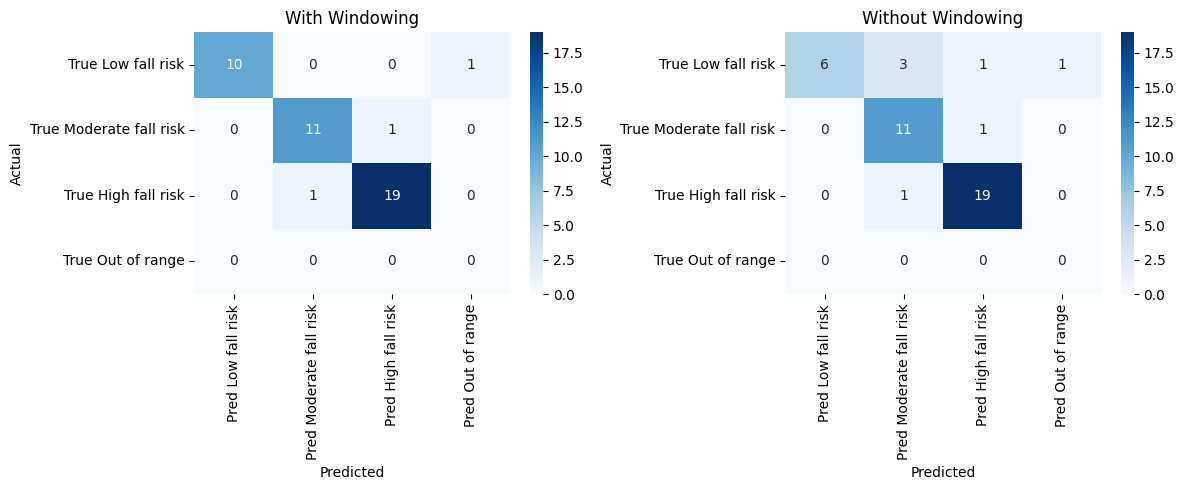

In [ ]:
"""
Confusion Matrix Heatmaps for Fall-Risk Prediction
=================================================

Purpose:
--------
Visualize the classification performance of the windowed and non-windowed POMA models
using heatmaps, which provide an intuitive representation of how predicted fall-risk
categories align with the true labels.

Details:
--------
- Rows correspond to the true fall-risk category (Actual).
- Columns correspond to the predicted fall-risk category (Predicted).
- The diagonal cells indicate correct predictions; off-diagonal cells show misclassifications.
- Color intensity indicates the count of predictions in each category.

Libraries:
----------
- seaborn (sns) for heatmap plotting
- matplotlib.pyplot for figure layout

Output:
-------
A side-by-side comparison of the confusion matrices for the two models.
"""

import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ==============================
# Heatmap: Windowing Model
# ==============================
sns.heatmap(
    cm_windowing_df,          # DataFrame with counts
    annot=True,               # Display numbers in cells
    fmt="d",                  # Integer format
    cmap="Blues",             # Color map
    ax=axes[0]                # Plot on left subplot
)
axes[0].set_title("With Windowing")   # Subplot title
axes[0].set_ylabel("Actual")          # Y-axis label
axes[0].set_xlabel("Predicted")       # X-axis label

# ==============================
# Heatmap: Non-Windowing Model
# ==============================
sns.heatmap(
    cm_non_windowing_df,      # DataFrame with counts
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=axes[1]                # Plot on right subplot
)
axes[1].set_title("Without Windowing")
axes[1].set_ylabel("Actual")
axes[1].set_xlabel("Predicted")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
